# 自己回帰モデル

## 理論

### モデル (自己回帰モデル)

<div style="padding: 10px; margin-bottom: 10px; border: 1px solid #333333; border-radius: 10px;">

　$t = 1, 2, \cdots, T $ のとき, 自己回帰モデルは以下のように定式化される.

$$
    y_t = 
        \underbrace{\delta_{0} + \delta_{1} t}_{\text{trend}} 
        + \sum_{k=1}^{p} \underbrace{\phi_{k} y_{t-k}}_{\text{ar}}
        + \sum_{i=1}^{s-1} \underbrace{\gamma_{i} d_{i}}_{\text{seasonal}}
        + \sum_{j=1}^{m} \underbrace{\kappa_{j} x_{t, j} }_{\text{explanatory}}
        + \underbrace{\varepsilon_t}_{\text{irregular}}
$$

ここで, 

- $y_t$ : 時点 $t$ での応答変数
- $\delta_0, \delta_1$ : 確定変数としてのトレンド項係数
- $p$ : 自己回帰成分の次数
- $s$ : 季節成分の基本周期
- $d_i$ : 時点 $t$ が季節 $i$ 時点であるかどうかを示すダミー変数
    
$$
    d_i = \begin{cases}
        1 &(t \equiv i \pmod s) \\
        0 &(\text{otherwise})
    \end{cases}
$$
    
- $\gamma_i$ : 季節 $i$ 時点の効果
- $x_{t, j}$ : $j$ 番目の時点 $t$ での回帰成分
- $\kappa_{j}$ : $j$ 番目の回帰係数
- $\varepsilon_t$ : 誤差項

である.

</div>


## statsmodels での自己回帰モデル

<u>Documents</u>

- API Docs
    - [statsmodels.tsa.ar_model.AutoReg](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg)
        - [statsmodels.tsa.ar_model.AutoReg.fit](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.fit.html#statsmodels.tsa.ar_model.AutoReg.fit)
    - [statsmodels.tsa.ar_model.ar_select_order](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.ar_select_order.html)

### 関係モジュール

#### statsmodels.tsa.ar_model.AutoReg

`class statsmodels.tsa.ar_model.AutoReg(endog, lags, trend='c', seasonal=False, exog=None, hold_back=None, period=None, missing='none', deterministic=None, old_names=False)`

- パラメータ
    - `endog` :
        1次元の応答変数 ($y_t$) で, もし欠損値がある場合は `missing` オプションでチェックしない限りエラーが発生.
    - `lags` :
        AR次数 ($p$)
    - `trend` :
        確定変数表現のトレンド項
        | `trend` |                              |
        | ------- | ---------------------------- | 
        | `n`     | $ 0 $                        |
        | `c`     | $ \delta_{0}$                |
        | `ct`    | $ \delta_{0} + \delta_{1} t$ |
        | `t`     | $ \delta_{1} t$              |
    - `seasonal` : 
        モデルに季節成分を含む場合には `True`.
    - `exog` : 
        外生変数
    - `period` : 
        `seasonal = True` の場合にのみ定義が必要. `endog` の `index`が `freq` の定義されたものの場合には引数指定する必要はないが, そうでない場合や基本周期を設定したい場合には数字を指定する.
    - `missing` : 
        | `missing` |                                     |
        | --------- | ----------------------------------- |
        | `none`    | 欠損値チェックをしない (デフォルト)      |
        | `drop`    | 欠損値があった場合に drop する.         |
        | `raise`   | 欠損値があった場合にエラーを raise する. |

##### AutoReg.fit

　XXXX

#### statsmodels.tsa.ar_model.ar_select_order

　XXXX

### 活用例

#### AirPassengers

　`AutoReg` モジュールを用いて実際にモデルを構築してみる.


##### 使用ライブラリインポート・初期設定

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()
pd.plotting.register_matplotlib_converters()
sns.mpl.rc("figure", figsize=(18, 6))
sns.mpl.rc("font", size=14)

##### AirPassengers データの確認

　自己回帰モデルを適応する前に以下の観点でデータの確認をする.
 
- 実データの波形 : 時系列にどのような挙動を示したデータなのかを捉える.
- データのばらつき : 以下 2 つのグラフを用いて視覚的にばらつき・分布情報を捉える.
    - 箱ひげ図
    - ヒストグラム
- 正規分布との類似 : Q-Q プロットを用いて元データがどれだけ正規分布の理論値と近いのかを視覚的に捉える.

<u>実データの波形</u>

　周期的な増減と経年通しての上昇トレンドが見て取れる.

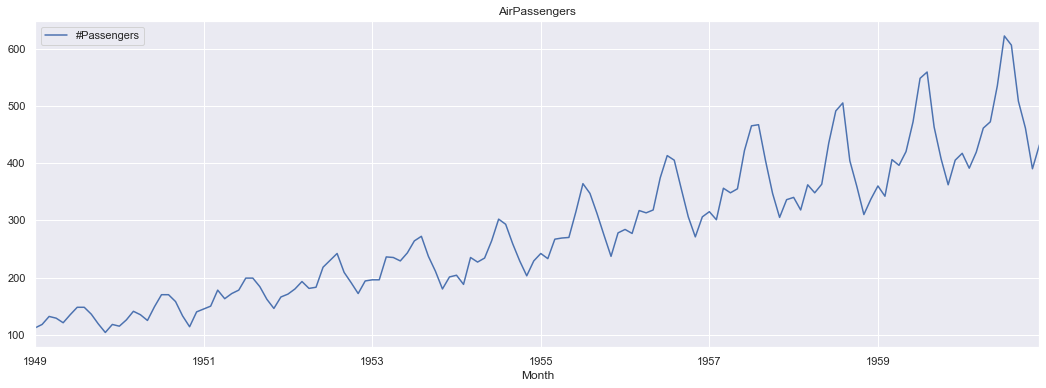

In [2]:
# AirPassengers データ
url = "https://raw.githubusercontent.com/sndpgm/analytics-sandbox/main/docs/analytics/datasets/air_passengers/air_passengers.csv"
data = pd.read_csv(url)
data.index = pd.to_datetime(data["Month"])
data.drop(columns=["Month"], inplace=True)
data.index.freq = "MS"

fig, ax = plt.subplots()
ax = data.plot(ax=ax, title="AirPassengers")
plt.show()

<u>データのばらつき</u>

　最小値から 400 ほどまである程度散らばりが確認され, 右裾が長い分布であることが分かる.

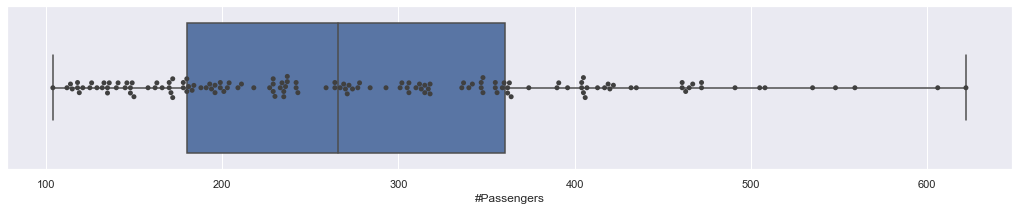

In [3]:
fig, ax = plt.subplots(figsize=(18, 3))
ax = sns.boxplot(x="#Passengers", data=data)
ax = sns.swarmplot(x="#Passengers", data=data, color=".25")
plt.show()

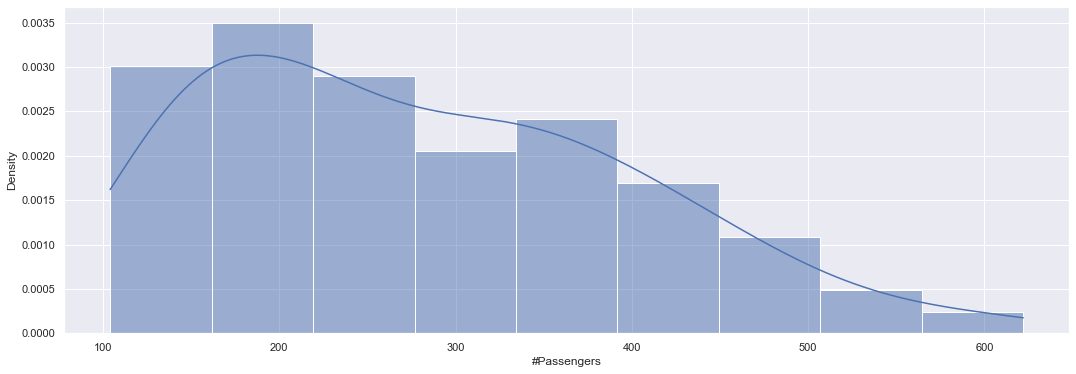

In [4]:
fig, ax = plt.subplots()
sns.histplot(data["#Passengers"], stat="density", kde=True, ax=ax)
plt.show()

<u>正規分布との類似度</u>

　値の小さなところ, 大きなところが正規分布とは外れている.

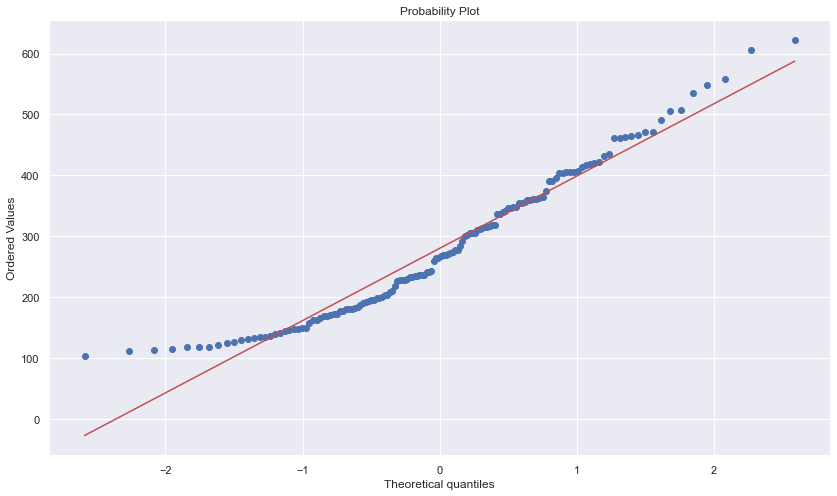

In [5]:
fig, ax = plt.subplots(figsize=(14, 8))
stats.probplot(data["#Passengers"], plot=plt)
plt.show()

　時系列データを扱うとき, 原系列がトレンド要因・季節要因・誤差要因の基本成分の合成で成立していると捉えることがよくあるが, このとき, 原系列を $O(t)$, トレンド要因を $T(t)$, 季節要因を $S(t)$, 誤差要因を $I(t)$ とすれば

$$
    \begin{align}
        &\text{(加法モデル)} \quad O(t) = T(t) + S(t) + I(t) \\
        &\text{(乗法モデル)} \quad O(t) = T(t) \times S(t) \times I(t)
    \end{align}
$$

と分解できるという考え方である. [`statsmodels.tsa.seasonal_decompose`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) を用いて分解してみる.

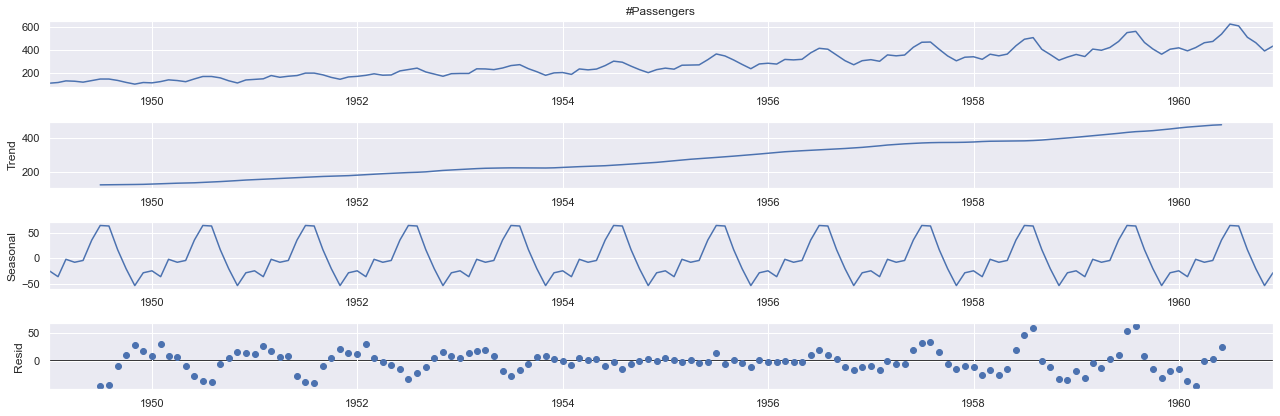

In [6]:
decomposition = seasonal_decompose(data["#Passengers"], model="additive")
decomposition.plot()
plt.show()

　加えて, 自己相関係数と偏自己相関係数の推移についても確認してみると, 特に偏自己相関係数のグラフからラグ 11 で相関が見られるので, 周期 12 の季節成分が含まれると判断できる.

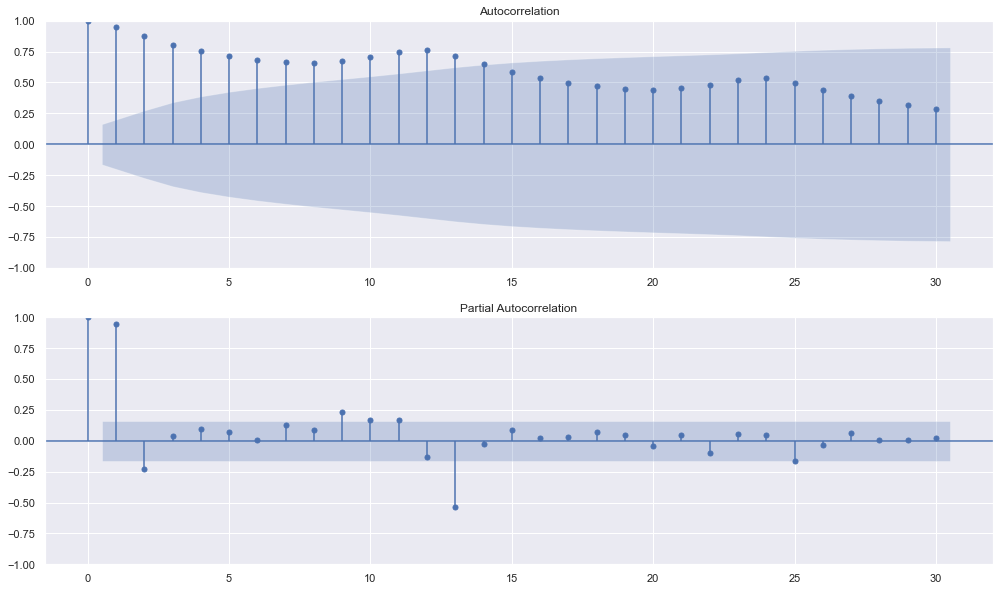

In [7]:
fig = plt.figure(figsize=(17, 10))
ax1 = fig.add_subplot(211)
fig = plot_acf(data, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data, lags=30, method="ywm", ax=ax2)
plt.show()

##### モデリング

In [8]:
# scikit-learn でMAPE算出モジュールとデータを訓練用とテスト用に分割するモジュールを import
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [9]:
# テストデータを 20% ととしてデータを分割する.
# ただし, 時系列データのためデータ順序がシャッフルされないように設定する.
test_size = 0.20
shuffle = False
data_train, data_test = train_test_split(data, test_size=test_size, shuffle=shuffle)

In [10]:
# lags = 12 とすることで季節成分を吸収させる.
lags = 12
trend = "n"
model = AutoReg(data_train, lags=lags, trend=trend)
model_fitted = model.fit(cov_type="HC0")
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                    AutoReg(12)   Log Likelihood                -400.847
Method:               Conditional MLE   S.D. of innovations             11.855
Date:                Wed, 13 Jul 2022   AIC                            827.694
Time:                        18:42:21   BIC                            861.945
Sample:                    01-01-1950   HQIC                           841.567
                         - 07-01-1958                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
#Passengers.L1      0.5487      0.076      7.175      0.000       0.399       0.699
#Passengers.L2     -0.3050      0.092     -3.301      0.001      -0.486      -0.124
#Passengers.L3      0.2667      

In [11]:
# 予測期間はテストデータの期間
start = data_test.index.min()
end = data_test.index.max()

# 予測値とともに 95% 信頼区間も算出
alpha = 0.05

# get_prediction メソッドにより予測結果インスタンスを取得
# 信頼区間を求める場合には予測結果インスタンスを経由し conf_int メソッドから計算
predict_result = model_fitted.get_prediction(start=start, end=end)

# 予測値 Series を取得
predict = predict_result.predicted_mean

# 信頼区間の格納された DataFrame を取得
df_ci = predict_result.conf_int(alpha=alpha)

# 予測値と信頼区間を一つの DataFrame にまとめる
df_predict = pd.DataFrame(predict)
df_predict = df_predict.join(df_ci)

# 結果の確認
df_predict.head(10)

,predicted_mean,lower,upper
1958-08-01,517.882984,494.646958,541.119011
1958-09-01,477.418659,450.914089,503.923230
1958-10-01,408.592816,382.088094,435.097537
1958-11-01,359.562948,332.962043,386.163853
1958-12-01,380.015101,353.322739,406.707463
1959-01-01,380.625636,353.883098,407.368173
1959-02-01,366.548655,339.794543,393.302767
1959-03-01,389.562986,362.808813,416.317160
1959-04-01,377.591770,350.713374,404.470166
1959-05-01,401.653944,374.775454,428.532435


In [12]:
mape = mean_absolute_percentage_error(data_test, df_predict["predicted_mean"])
mape_msg = f"MAPE: {round(mape, 3)}"
print(mape_msg)

MAPE: 0.1


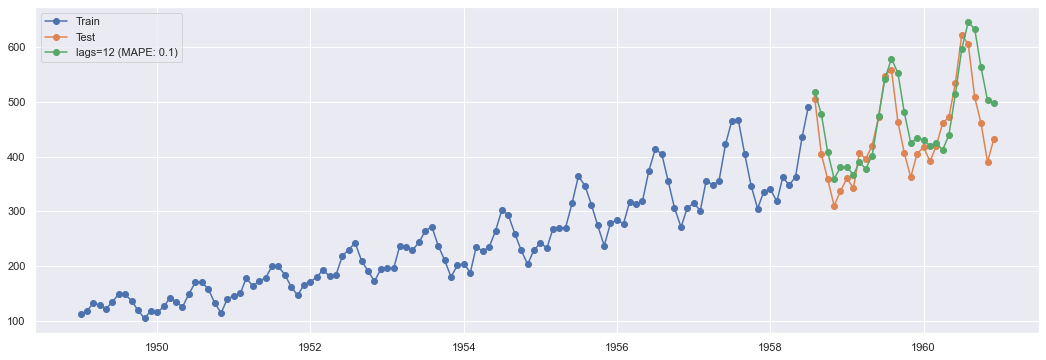

In [13]:
fig, ax = plt.subplots()
plt.plot(data_train, marker="o", label="Train")
plt.plot(data_test, marker="o", label="Test")
plt.plot(df_predict["predicted_mean"], marker="o", label=f"lags={lags} ({mape_msg})")

plt.legend()
plt.show()

　`ar_select_order` メソッドを用いて最適化な `lags` をもったモデルを選定することができる. 下記の結果から `lags=12` まで確認したところ `lags=12` が最適である.

In [14]:
maxlag = 12
model_selected = ar_select_order(data_train, maxlag=maxlag, trend=trend)
print(model_selected.ar_lags)
model_selected_fitted = model_selected.model.fit()
print(model_selected_fitted.summary())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
                            AutoReg Model Results                             
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                    AutoReg(12)   Log Likelihood                -400.847
Method:               Conditional MLE   S.D. of innovations             11.855
Date:                Wed, 13 Jul 2022   AIC                            827.694
Time:                        18:42:22   BIC                            861.945
Sample:                    01-01-1950   HQIC                           841.567
                         - 07-01-1958                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
#Passengers.L1      0.5487      0.087      6.282      0.000       0.378       0.720
#Passengers.L2     -0.3050      0.098     -3.123      0.002      -0.496     

　トレンド項についても AR 成分に全て含まれたモデルとなっているので, トレンド項を別で定義したモデルを検討する.

In [15]:
# lags = 12 とすることで季節成分を吸収させる.
# トレンドは定数と時系列推移する成分を入力.
lags = 12
trend = "ct"
model_trend = AutoReg(data_train, lags=lags, trend=trend)
model_trend_fitted = model_trend.fit(cov_type="HC0")
print(model_trend_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                    AutoReg(12)   Log Likelihood                -395.231
Method:               Conditional MLE   S.D. of innovations             11.226
Date:                Wed, 13 Jul 2022   AIC                            820.463
Time:                        18:42:22   BIC                            859.984
Sample:                    01-01-1950   HQIC                           836.470
                         - 07-01-1958                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.4863      8.902      3.088      0.002      10.039      44.934
trend               0.6687      0.279      2.395      0.017       0.122       1.216
#Passengers.L1      0.4761      

In [16]:
# 同様にして予測値を算出し, MAPEを計算する.
predict_result_trend = model_trend_fitted.get_prediction(start=start, end=end)
predict_trend = predict_result_trend.predicted_mean
df_ci_trend = predict_result_trend.conf_int(alpha=alpha)
df_predict_trend = pd.DataFrame(predict_trend)
df_predict_trend = df_predict_trend.join(df_ci_trend)

# MAPE の計算
mape_trend = mean_absolute_percentage_error(
    data_test, df_predict_trend["predicted_mean"]
)
mape_msg_trend = f"MAPE: {round(mape_trend, 3)}"
print(mape_msg_trend)

MAPE: 0.075


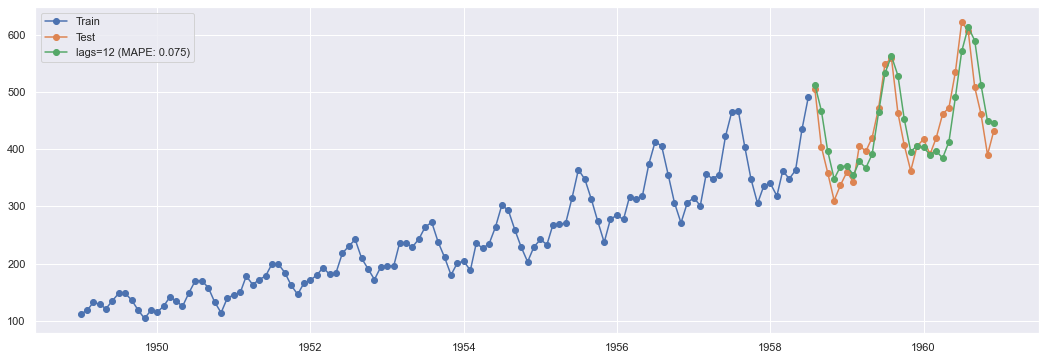

In [17]:
fig, ax = plt.subplots()
plt.plot(data_train, marker="o", label="Train")
plt.plot(data_test, marker="o", label="Test")
plt.plot(
    df_predict_trend["predicted_mean"],
    marker="o",
    label=f"lags={lags} ({mape_msg_trend})",
)

plt.legend()
plt.show()

　トレンド項を入れたモデルの方が $2.5%$ 精度改善が見られた.